In [1]:
import pandas as pd
import numpy as np
import praw
import json 
import csv
from   sklearn.linear_model import LogisticRegression
from   sklearn.tree import DecisionTreeClassifier
from   sklearn.ensemble import RandomForestClassifier
from   xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_parquet('reddit_bal.parquet')

#function to remove special characters and lower case text
def clean_text(text):
    pattern = r'[^a-zA-Z0-9\s]'
    text_cleaned = re.sub(pattern, '', text)
    cleaned_text = text_cleaned.lower()
    return cleaned_text

df['Comment'] = df['Comment'].apply(clean_text)


#Encoding target variable
label_encoder = LabelEncoder()
df['Author Occupation'] = label_encoder.fit_transform(df['Author Occupation'])


In [3]:
# Using TF-IDF vectorizer for feature extraction
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

train,test = train_test_split(df, test_size=0.2, random_state=123)

X_train = tfidf_vectorizer.fit_transform(train['Comment'])
y_train = train['Author Occupation']

X_test = tfidf_vectorizer.transform(test['Comment'])
y_test = test['Author Occupation']


In [4]:
#Function for algorithm selection
def model_to_use(input_ml_algo):
  if input_ml_algo == 'DT':
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
  elif input_ml_algo == 'RF':
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
  elif input_ml_algo == 'XGBC':
    model = XGBClassifier()
    model.fit(X_train, y_train)
  elif input_ml_algo =='LR':
    model = LogisticRegression()
    model.fit(X_train, y_train)
  elif input_ml_algo == 'MNB':
    model = MultinomialNB()
  model.fit(X_train, y_train)
  return model

array(['Doctor', 'Others', 'Veterinarian'], dtype=object)

In [32]:
#Function for model evaluation
def model_evaluation(model,X_test,y_test):
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy:", accuracy)
  col1 = label_encoder.inverse_transform([0,1,2])
  cm = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      columns=col1,index=col1)
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.title('Confusion Matrix')
  plt.show()

In [6]:
'''
I used several algorithms and settled for Random forest, it gave me the best performance of the models.
You can experiment with the other models if needed. 
Use 'LR' for Logistic Regression,
'DT' for Decision Tree,
'MNB' for MultinomialNB,
'XGBC' for the XGboost classifier
'''
model2 = model_to_use('RF')

Accuracy: 0.9504878452125021


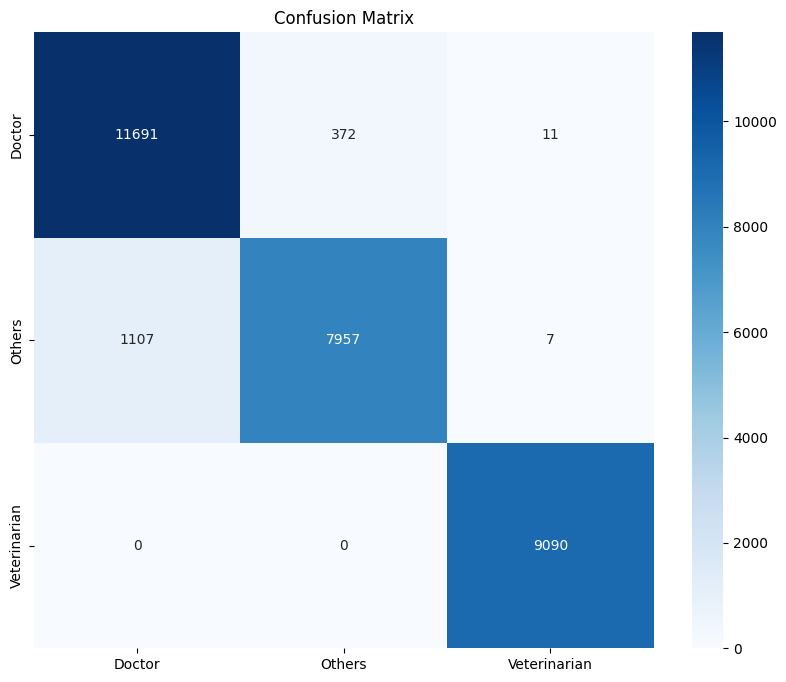

In [33]:
model_evaluation(model2,X_test,y_test)

In [8]:
pred = model2.predict(X_test)

In [10]:
# Predicting the Author occupation of the comments from the Postgres database

#Please follow the steps when testing

'''
1. Apply the cleaning function on the comments
2. Apply the vectorizer object on the comments
3. Apply the model to carry out the classification
'''

df2 = pd.read_csv('reddit_usernames_comments.csv')

In [12]:
df2['comments'] = df2['comments'].apply(clean_text)
X = tfidf_vectorizer.transform(df2['comments'])
preds = model2.predict(X)
preds_enc = label_encoder.inverse_transform(preds)
new_df = pd.DataFrame({
    'Comments': df2['comments'],
    'Author Occupation': preds_enc
})
new_df.head()

,Comments,Author Occupation
0,i think a lot of other people made some good p...,Others
1,no and it doesnt suit you based on what youve ...,Others
2,its just the adjustment period to any new plac...,Others
3,i am living this currently and when a trainee ...,Others
4,well thats disappointing that there is no chan...,Others
